author: Samuel Begg

date: 06/04/2024

Compute Fisher information for a periodically driven XY model, as discussed in Mishra, Bayat, Phys. Rev. Lett. 127, 080504 (2021)

1. Define simulation parameters

In [1]:
import methods
import numpy as np
import scipy.linalg as lin
from datetime import datetime
import copy
from joblib import Parallel, delayed

stem0 = '/Users/samuelbegg/'
stem = stem0  + 'Documents/Projects/Sensing/'

# System parameters for periodic boundary condition spin chain.
J = 1.0
gamma = 1
h1 = 0 # The periodic field is set to zero when considering the ground-state
sites = 4
boundary_conditions = 'ABC' #'PBC' = periodic boundary conditions or 'ABC' = anti-periodic boundary conditions

# Notes: 
# The boundary conditions reflects the fermion parity of the ground-state.
# The Fourier transform definition is automatically adjusted based on number sites and boundary conditions, as in arXiv:1707.02400.

#Initial state
initial_state = 'ground_state' 
# 'ground_state': starts in the system ground-state. 
# 'flips': manually flips specific spins (with the rest down), see below. Default: single flip. Odd number of excitations (spin) = even parity (fermions) = PBC. 
# 'momentum': a k = 0 momentum state. Even parity = PBC.
# 'spin_up': all spins up, odd number excitations (spin) = even parity = PBC, even number excitations (spin) = odd parity (fermions) = ABC

# Sensing parameters
phasepoints = 401 # points to sampling h0
h0mat = np.linspace(-2,2,phasepoints)  # range of points to sample
sub_system_range = np.arange(1,int(3)+1) # range of subsystem sizes for evaluating Fisher information
sub_system_edge = 0 #index of the first site in the sub-system, 0 is the left boundary site.

# Computational 
tol = 10**(-8) # when evaluating the Fisher information we don't consider singular terms for which |w[rr] + w[ss]| < tol 
shift = 10**(-6) # finite division size for calculating derivative of reduced density matrix, i.e. drho/dh0 ~ (rho(h0) - rho(h0 + shift))/shift for the order2 version
derivative_estimator = 'order2' # 2nd order = 'order2' or 4th order 'order4' approximation for the derivative of reduced density matrix
num_cores = 16  # number of cores to parallelize with
save_results = 'bin' # 'save' or 'bin' (don't save)



2. Calculate Fisher information for ground state

In [2]:
Fishermat = np.zeros([np.size(sub_system_range),np.size(h0mat)])

#Calculate fisher information for different subsystem sizes and h0 values
output = Parallel(n_jobs=num_cores)(delayed(methods.Fisher_Groundstate)(J, gamma, h0mat[uu], h1, sites, sub_system_range, sub_system_edge, tol, shift, derivative_estimator, boundary_conditions) for uu in range(0,np.size(h0mat)))

Fisher_mat = []

particle_numberL = []

for kk in range(0,phasepoints):
    
    data = output[kk]

    Fisher_mat = Fisher_mat + [data[0]]

    particle_numberL = particle_numberL + [data[1]]

Fishermat= np.asarray(Fisher_mat)

particle_number = np.asarray(particle_numberL)


0:00:00.000217 Time to calculate the initial correlation matrices
0:00:00.000083 Time to evaluate Gamma matrix for single h0
0:00:00.000166 Time to calculate the initial correlation matrices
0:00:00.000062 Time to evaluate Gamma matrix for single h0
0:00:00.000184 Time to calculate the initial correlation matrices
0:00:00.000061 Time to evaluate Gamma matrix for single h0
0:00:00.000162 Time to calculate the initial correlation matrices
0:00:00.000060 Time to evaluate Gamma matrix for single h0
0:00:00.000161 Time to calculate the initial correlation matrices
0:00:00.000206 Time to calculate the initial correlation matrices
0:00:00.000059 Time to evaluate Gamma matrix for single h0
0:00:00.000080 Time to evaluate Gamma matrix for single h0
0:00:00.000164 Time to calculate the initial correlation matrices
0:00:00.000062 Time to evaluate Gamma matrix for single h0
0:00:00.000183 Time to calculate the initial correlation matrices
0:00:00.000061 Time to evaluate Gamma matrix for single h0


3. Calculate ground state Fisher information for different gamma values

In [3]:
#Want to see scaling for some different gamma values too
gmat = [0.1,0.5,1]

output = Parallel(n_jobs=num_cores)(delayed(methods.Fisher_Groundstate)(J, gmat[gg], 1.0, h1, sites, sub_system_range, sub_system_edge, tol, shift, derivative_estimator, boundary_conditions) for gg in range(0,np.size(gmat)))

Fisher_mat = []

particle_numberG = []

for kk in range(0,np.size(gmat)):
    
    data = output[kk]

    Fisher_mat = Fisher_mat + [data[0]]

    particle_numberG = particle_numberG + [data[1]]

FishermatGamma= np.asarray(Fisher_mat)

particle_numberG = np.asarray(particle_numberG)


0:00:00.000198 Time to calculate the initial correlation matrices
0:00:00.000187 Time to calculate the initial correlation matrices
0:00:00.000080 Time to evaluate Gamma matrix for single h0
0:00:00.000073 Time to evaluate Gamma matrix for single h0
0:00:00.000174 Time to calculate the initial correlation matrices
0:00:00.000173 Time to calculate the initial correlation matrices
0:00:00.000062 Time to evaluate Gamma matrix for single h0
0:00:00.000064 Time to evaluate Gamma matrix for single h0
0:00:00.000205 Time to calculate the initial correlation matrices
0:00:00.000077 Time to evaluate Gamma matrix for single h0
0:00:00.000189 Time to calculate the initial correlation matrices
0:00:00.000187 Time to calculate the initial correlation matrices
0:00:00.000065 Time to evaluate Gamma matrix for single h0
0:00:00.000065 Time to evaluate Gamma matrix for single h0
0:00:00.000216 Time to calculate the initial correlation matrices
0:00:00.000169 Time to calculate the initial correlation ma

Plot Fisher information for groundstates

In [4]:
if save_results == 'save':
    
    np.save('ResultsGS/gmat.npy',gmat)
    np.save('ResultsGS/Fisher_mat_Gamma.npy',FishermatGamma)
    np.save('ResultsGS/h0mat.npy',h0mat)
    #np.save('Fisher_mat.npy',Fishermat)
    np.save('ResultsGS/subsystem.npy',sub_system_range)

import matplotlib.pyplot as plt
plot_system_size_scaling = 'no'

if plot_system_size_scaling == 'yes':



    # for ss in range(1,np.size(sub_system_range),2):

    #     plt.plot(h0mat,Fishermat[:,ss],'--o',label = 'L=' + str(sub_system_range[ss]))

    # plt.ylabel(r'$F_{gs}$')
    # plt.xlabel(r'$h_0$')
    # plt.title('Ground state Fisher information with $N = $' + str(sites) + ', $\gamma=$' + str(gamma))
    # plt.legend()
    # plt.show()

    # x = np.linspace(0.25,1.5,1000)
    # plt.plot(x,2*x-1,'--r',label = r'$F \sim L^{2}$')
    # plt.plot(x,x-1,'-r',label = r'$F \sim L$')
    # plt.plot(np.log10(sub_system_range),np.log10(Fishermat[int(np.size(h0mat)/2),:]),label = r'$h_0=$' + str(np.round(h0mat[int(np.size(h0mat)/2)],3)))
    # #plt.plot(np.log10(sub_system_range),np.log10(Fishermat[35,:]),label = r'$h_0=$' + str(np.round(h0mat[35],3)))
    # plt.plot(np.log10(sub_system_range),np.log10(Fishermat[7,:]),label = r'$h_0=$' + str(np.round(h0mat[0],3)))
    # plt.xlabel(r'$L$')
    # plt.ylabel(r'$F_{gs}$')
    # plt.title('Ground state Fisher information with $N = $' + str(sites) + ', $\gamma=$' + str(gamma))
    # plt.legend()
    # plt.show()

    x = np.linspace(0.1,2.5,1000)
    plt.plot(x,2*x+2,'--r',label = r'$F \sim L^{2}$')
    plt.plot(x,x+2,'-r',label = r'$F \sim L$')



    ranges = np.arange(5,100)

    a0_0, a1 = np.polyfit(np.log10(sub_system_range[ranges]),np.log10(FishermatGamma[0,ranges]),1)
    plt.plot(x,a0_0*x+a1,'--k')

    print(a0_0)
    a0_1, a1 = np.polyfit(np.log10(sub_system_range[ranges]),np.log10(FishermatGamma[1,ranges]),1)
    plt.plot(x,a0_1*x+a1,'--k')
    print(a0_1)
    a0_2, a1 = np.polyfit(np.log10(sub_system_range[ranges]),np.log10(FishermatGamma[2,ranges]),1)
    plt.plot(x,a0_2*x+a1,'--k')
    print(a0_2)


    plt.plot(np.log10(sub_system_range),np.log10(FishermatGamma[0,:]),label = r'$\gamma=$' + str(np.round(gmat[0],3))+ r', $\eta = $' + str(np.round(np.real(a0_0),3)))
    plt.plot(np.log10(sub_system_range),np.log10(FishermatGamma[1,:]),label = r'$\gamma=$' + str(np.round(gmat[1],3))+ r', $\eta = $' + str(np.round(np.real(a0_1),3)))
    plt.plot(np.log10(sub_system_range),np.log10(FishermatGamma[2,:]),label = r'$\gamma=$' + str(np.round(gmat[2],3))+ r', $\eta = $' + str(np.round(np.real(a0_2),3)))
    plt.title('Ground state Fisher information with $N = $' + str(sites) + ', $h_0=1$')
    plt.xlabel(r'$\log_{10} L$')
    plt.ylabel(r'$\log_{10} F_{gs}$')
    plt.legend()
    plt.show()


/Users/samuelbegg/Library/Python/3.9/lib/python/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/samuelbegg/Library/Python/3.9/lib/python/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


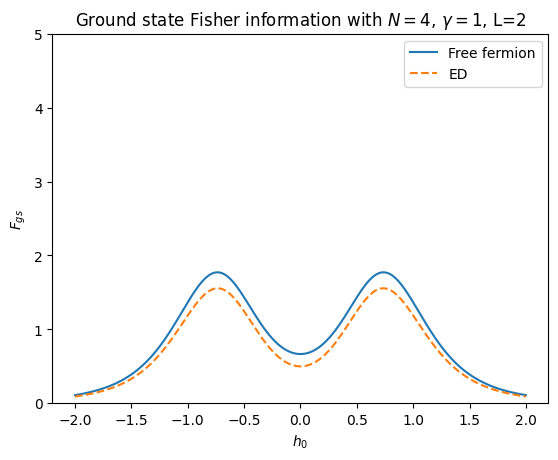

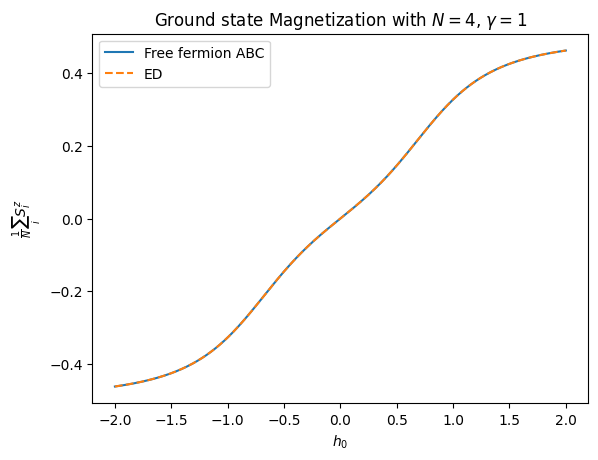

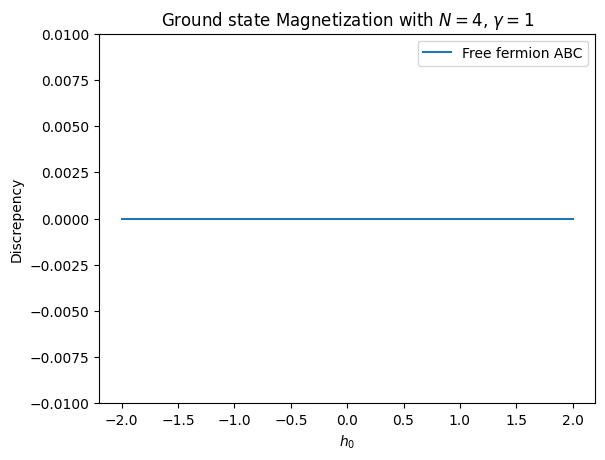

[-2.   -1.99 -1.98 -1.97 -1.96 -1.95 -1.94 -1.93 -1.92 -1.91 -1.9  -1.89
 -1.88 -1.87 -1.86 -1.85 -1.84 -1.83 -1.82 -1.81 -1.8  -1.79 -1.78 -1.77
 -1.76 -1.75 -1.74 -1.73 -1.72 -1.71 -1.7  -1.69 -1.68 -1.67 -1.66 -1.65
 -1.64 -1.63 -1.62 -1.61 -1.6  -1.59 -1.58 -1.57 -1.56 -1.55 -1.54 -1.53
 -1.52 -1.51 -1.5  -1.49 -1.48 -1.47 -1.46 -1.45 -1.44 -1.43 -1.42 -1.41
 -1.4  -1.39 -1.38 -1.37 -1.36 -1.35 -1.34 -1.33 -1.32 -1.31 -1.3  -1.29
 -1.28 -1.27 -1.26 -1.25 -1.24 -1.23 -1.22 -1.21 -1.2  -1.19 -1.18 -1.17
 -1.16 -1.15 -1.14 -1.13 -1.12 -1.11 -1.1  -1.09 -1.08 -1.07 -1.06 -1.05
 -1.04 -1.03 -1.02 -1.01 -1.   -0.99 -0.98 -0.97 -0.96 -0.95 -0.94 -0.93
 -0.92 -0.91 -0.9  -0.89 -0.88 -0.87 -0.86 -0.85 -0.84 -0.83 -0.82 -0.81
 -0.8  -0.79 -0.78 -0.77 -0.76 -0.75 -0.74 -0.73 -0.72 -0.71 -0.7  -0.69
 -0.68 -0.67 -0.66 -0.65 -0.64 -0.63 -0.62 -0.61 -0.6  -0.59 -0.58 -0.57
 -0.56 -0.55 -0.54 -0.53 -0.52 -0.51 -0.5  -0.49 -0.48 -0.47 -0.46 -0.45
 -0.44 -0.43 -0.42 -0.41 -0.4  -0.39 -0.38 -0.37 -0

In [5]:
#Comparison vs ED

ss = 1
plt.plot(h0mat,Fishermat[:,ss],label = 'Free fermion')

#Fisher vs h
ED_fisher = np.load('/Users/samuelbegg/Documents/Sensing/ed_results/Fisher.npy')
hzmat = np.load('/Users/samuelbegg/Documents/Sensing/ed_results/hzmat.npy')
plt.plot(hzmat,ED_fisher,'--',label='ED')
plt.ylabel(r'$F_{gs}$')
plt.xlabel(r'$h_0$')
plt.title('Ground state Fisher information with $N = $' + str(sites) + ', $\gamma=$' + str(gamma) + ', L=' + str(sub_system_range[ss]))
plt.legend()
plt.ylim(0,5)
plt.show()

#Sz vs h
ED_spin = np.load('/Users/samuelbegg/Documents/Sensing/ed_results/mag.npy')
hzmat = np.load('/Users/samuelbegg/Documents/Sensing/ed_results/hzmat.npy')
plt.plot(h0mat,particle_number-0.5,label = 'Free fermion ' + boundary_conditions)
plt.plot(hzmat,ED_spin ,'--',label='ED')
plt.ylabel(r'$\frac{1}{N}\sum_i S^z_i$')
plt.xlabel(r'$h_0$')
plt.title('Ground state Magnetization with $N = $' + str(sites) + ', $\gamma=$' + str(gamma))
plt.legend()
#plt.ylim(0,1)
plt.show()

#Discrepancy Sz vs Exact Diagonalization
plt.plot(h0mat,particle_number-0.5 - ED_spin,label = 'Free fermion ' + boundary_conditions)
plt.ylabel(r'Discrepency')
plt.xlabel(r'$h_0$')
plt.title('Ground state Magnetization with $N = $' + str(sites) + ', $\gamma=$' + str(gamma))
plt.legend()
plt.ylim(-0.01,0.01)
plt.show()


print(hzmat)
print(h0mat)